In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import matplotlib
import matplotlib.font_manager as fm
arial_font_path = '/cellar/users/snwright/Fonts/msfonts/Arial.TTF'
fm.fontManager.addfont(arial_font_path)
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25


In [4]:
datadir='/cellar/users/snwright/Data/RareCommon/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/StudySelection/'

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
pc_nodes = pd.read_csv(os.path.join(datadir, 'inputs', 'pcnet2_0_nodes.txt' ), sep='\t', header=None, names=['Entrez', 'degree']).Entrez.values

In [7]:
azd = 'MONDO_0004975'

# No UKB filtering

## Load Data

### GCat Study Info

In [8]:
study_info = pd.read_csv(os.path.join(datadir,'GWASCatalog', 'cleaned_gwas-catalog-v1.0.3.1-studies-r2025-03-26.tsv'), sep="\t")
study_info = study_info.dropna(subset='TRAIT_CODE_CLEAN')
study_info['TRAIT_CODE_CLEAN'] = study_info['TRAIT_CODE_CLEAN'].apply(lambda z: z.split('/')[-1].replace(':', '_'))

In [9]:
gwas_genes_meta = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedMar28'), sep="\t")
gwas_genes_meta.columns

Index(['PUBMEDID', 'DATE', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'MAPPED_GENE', 'SNP_GENE_IDS', 'SNP_ID_CURRENT', 'INTERGENIC',
       'P-VALUE', 'OR or BETA', 'MAPPED_TRAIT', 'MAPPED_TRAIT_URI',
       'STUDY ACCESSION', 'GENOTYPING TECHNOLOGY', 'TRAIT_CODE'],
      dtype='object')

In [10]:
gwas_genes= pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedJan29.entrez'), sep="\t")
gwas_genes = gwas_genes.merge(gwas_genes_meta.loc[:, ("PUBMEDID", 'DISEASE/TRAIT', 'MAPPED_GENE', 'SNP_GENE_IDS', 
                          'MAPPED_TRAIT', 'STUDY ACCESSION', 'INITIAL SAMPLE SIZE', 'P-VALUE')],
                             on=["PUBMEDID", 'DISEASE/TRAIT', 'MAPPED_GENE', 'SNP_GENE_IDS',
                                 'MAPPED_TRAIT', 'STUDY ACCESSION', 'P-VALUE'], how='inner')

In [11]:
gwas_genes = gwas_genes[gwas_genes.Entrez.isin(pc_nodes)]

In [12]:
gwas_genes.shape

(327974, 16)

In [13]:
study_info.drop_duplicates(subset=['STUDY ACCESSION', "DISEASE/TRAIT", 'INITIAL SAMPLE SIZE','MAPPED_TRAIT', 'MAPPED_TRAIT_URI']).shape

(19450, 29)

In [14]:
gwas_genes = gwas_genes.drop(columns=['TRAIT_CODE']).merge(study_info.drop(columns=['ASSOCIATION COUNT', 'SUMMARY STATS LOCATION']), 
                      on=['STUDY ACCESSION', "DISEASE/TRAIT", 'INITIAL SAMPLE SIZE','MAPPED_TRAIT', 'MAPPED_TRAIT_URI'],
                                             how='left')
gwas_genes.shape

(327974, 37)

In [14]:
gwas_genes.nunique()

PUBMEDID                         4785
DATE_x                           2902
DISEASE/TRAIT                   23268
MAPPED_GENE                     13654
SNP_GENE_IDS                    13654
INTERGENIC                          1
P-VALUE                          2278
OR or BETA                     118232
MAPPED_TRAIT                     7088
MAPPED_TRAIT_URI                 7088
STUDY ACCESSION                 32065
logp                             2225
from                            13654
Entrez                          13654
INITIAL SAMPLE SIZE             10100
DATE ADDED TO CATALOG            1746
PUBMED ID                        3067
FIRST AUTHOR                     2330
DATE_y                           2140
JOURNAL                           514
LINK                             3067
STUDY                            3066
REPLICATION SAMPLE SIZE          1398
PLATFORM [SNPS PASSING QC]       3799
GENOTYPING TECHNOLOGY               2
SUBMISSION DATE                     0
STATISTICAL 

In [15]:
import re
def extract_sample_size(s):
    if isinstance(s, str):
        # Find all occurrences of numbers which may include commas.
        matches = re.findall(r'\d[\d,]*', s)
        # Remove commas and convert each match to an integer, then sum them up.
        return sum(int(num.replace(',', '')) for num in matches)
    else:
        return np.nan

In [16]:
study_info['N'] = study_info['INITIAL SAMPLE SIZE'].apply(lambda x: extract_sample_size(x))

In [17]:
ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez'),sep='\t', low_memory=False,
                            usecols=['Gene Symbol', 'Ensembl ID', 'Gene Type', 'CHR', 'Location', 'Reported Trait', 'Trait Label', 
                                     'Trait Ontology id', 'EFO synonym', 'P-value', 'PMID', 'TRAIT_CODE', 'Entrez'])
ravar_genes = ravar_genes[ravar_genes.Entrez.isin(pc_nodes)]
#replace '−' with '-'
#ravar_genes['P-value'] = ravar_genes['P-value'].apply(lambda x: float(x.replace('−','-')) if type(x) == str else float(x))
#ravar_genes['TRAIT_CODE'] = ravar_genes['Trait Ontology id'].apply(lambda x: x.replace(":", "_") if type(x) == str else x)

In [18]:
ravar_genes.shape

(75799, 13)

## Filter RAVAR

In [19]:
# remove any with 'Exclude' annotation
rv_study_info = pd.read_csv(os.path.join(datadir,'RAVAR', 'rv_study_info_cleaned_with_manual_mapped_Mar28.tsv'), sep='\t', index_col=0)
rv_study_info = rv_study_info[(~rv_study_info.COHORT.isin(['Exclude', 'Exlcude', 'Exlclude', 'Review'])) & (rv_study_info['Classification']!='Exclude')]

In [20]:
print(ravar_genes.shape)
ravar_genes = ravar_genes.merge(rv_study_info.loc[:, ('Reported Trait', 'PMID', 'MAPPED_TRAIT_CLEAN', 'TRAIT_CODE_CLEAN')], 
                                on=['Reported Trait', 'PMID'], how='inner')
print(ravar_genes.shape)
study_counts = ravar_genes.groupby(['Reported Trait', 'PMID']).Entrez.nunique().reset_index()
study_counts = study_counts.rename(columns={'Entrez': 'GeneCount'})

(75799, 13)
(62020, 15)


In [21]:
print(ravar_genes.shape)
ravar_genes = ravar_genes.merge(study_counts[study_counts.GeneCount >= 3], on=['Reported Trait', 'PMID'])
rv_study_info = rv_study_info.merge(study_counts, on = ['Reported Trait', 'PMID'])
print(ravar_genes.shape)

(62020, 15)
(60374, 16)


In [22]:
rv_study_info = rv_study_info[rv_study_info.GeneCount>= 3]
rv_start= rv_study_info['TRAIT_CODE_CLEAN'].nunique()
rv_start

1121

### Embed the reported traits and mapped traits

In [23]:
# identify and expand acronyms
import re
def extract_acronyms(strings):
    """
    Extract acronyms from a list of strings.
    Acronyms are identified as words that consist entirely of uppercase letters.
    
    Args:
        strings (list of str): List of strings to search for acronyms.
    
    Returns:
        set: A set of unique acronyms found across the provided strings.
    """
    # Using \b[A-Z]{2,}\b to match words with 2 or more uppercase letters.
    # Adjust the {2,} if you also want to capture single-letter acronyms.
    acronym_pattern = re.compile(r'\b[A-Z]{2,}\b')
    acronyms = set()
    for text in strings:
        found = acronym_pattern.findall(text)
        acronyms.update(found)
    return acronyms

In [24]:
common_acronyms = {
    'LDL': 'low density lipoprotein',
    'HDL': 'high density lipoprotein',
    'BMI': 'body mass index',
    'VLDL': 'very low density lipoprotein',
    'IL': 'interleukin',
    'IDL': 'intermediate density lipoprotein',
    'FVC': 'forced vital capacity',
    'FEV': 'forced expiratory volume',
    'COVID': 'coronavirus',
    'HIV': 'human immunodeficiency virus',
    'SARS': 'severe acute respiratory syndrome',
    'APOE': 'apolipoprotein E',
    'APOB': 'apolipoprotein B',
    'APOA': 'apolipoprotein A',
}

acronym_expansions = {
    'ldl': 'low density lipoprotein',
    'hdl': 'high density lipoprotein',
    "FAW3": 'omega-3 polyunsaturated fatty acid',
    "FAW6": 'omega-6 polyunsaturated fatty acid',
    "FEC": "Forced Expiratory volume",
    "FEV": "Forced Expiratory volume",
    "HIV": "Human Immunodeficiency Virus",
    "IV": "4",
    "LDH": "lumbar disc herniation",
    "NHDL": 'non High density ipoprotein',
    "NSAID": 'nonsteroidal anti inflammatory drug',
    "ACACE": "Acetoacetate",                                
    "ACE": "Acetate",             
    "ALA": "Alanine",                       # An essential omega-3 fatty acid
    "ALB": "Albumin",                                    # Main blood protein
    "APOB": "Apolipoprotein B",                           # Major protein of LDL particles
    "APOC": "Apolipoprotein C",                           # Protein component of several lipoproteins
    "BMI": "Body Mass Index",                            # Anthropometric measure
    "BP": "Blood Pressure",                              # Cardiovascular measure
    "CHOLA": "Cholesterol",                              # Cholesterol level (a general measure)
    "CIT": "Citrate",                                    # Metabolite in the citric acid cycle
    "CRP": "C-Reactive Protein",                         # Inflammatory marker
    "DHA": "Docosahexaenoic Acid",                       # An omega-3 fatty acid important in brain health
    "DISTRIB": "Distribution",                           # Typically referring to a dispersion measure (e.g. cell size distribution)
    "EGFR": "Estimated Glomerular Filtration Rate",      # Kidney function measure
    "FRAC": "Fraction",                                  # Proportion or fractional measure of a component
    "FVC": "Forced Vital Capacity",                      # Lung function measure
    "GLN": "Glutamine",                                  # An amino acid
    "GLOL": "Glycerol",                             # Summary measure across lipid traits
    "GLY": "Glycine",                                    # An amino acid
    "GP": "Glycoproteins",                        # Inflammatory biomarker (often abbreviated GlycA)
    "HDL": "High Density Lipoprotein",                   # ‘Good’ cholesterol carrier
    "HDLC": "High Density Lipoprotein Cholesterol",      # Cholesterol within HDL particles
    "HEEL": "Heel Bone Mineral Density",                 # Bone density measurement (often via heel ultrasound)
    "HEIGHT": "Height",                                  # Stature
    "HIS": "Histidine",                                  # An essential amino acid
    "IDL": "Intermediate Density Lipoprotein",           # A lipoprotein class between VLDL and LDL
    "IGF": "Insulin like Growth Factor",                 # A hormone linked to growth processes
    "III": "Type III",                                  # Often denotes a subclass or type (context dependent)
    "INS": "Insulin",                                    # Hormone regulating blood sugar
    "LA": "Linoleic Acid",                               # An essential omega-6 fatty acid
    "LDL": "Low Density Lipoprotein",                    # ‘Bad’ cholesterol carrier
    "LDLC": "Low Density Lipoprotein Cholesterol",       # Cholesterol within LDL particles
    "LIGHT": "Light Scatter",                            # Measure from flow cytometry (reflects cell granularity)
    "MUFA": "Monounsaturated Fatty Acids",               # Type of dietary fat
    "PC": "Phosphatidylcholine",                         # A major phospholipid in cell membranes
    "PHE": "Phenylalanine",                              # An amino acid
    "PUFA": "Polyunsaturated Fatty Acids",              # Type of dietary fat
    "PYR": "Pyruvate",                                   # Key metabolite in energy metabolism
    "RBC": "Red Blood Cell Count",                       # Red blood cells count
    "SCZD": "Schizophrenia",                             # Psychiatric disorder trait
    "SHBG": "Sex Hormone-Binding Globulin",              # Protein that binds sex hormones
    "SPHERED": "Spherical Diameter",                     # Typically refers to the diameter of lipoprotein particles
    "SYST": "Systolic Blood Pressure",                   # Upper value in blood pressure measurement
    "TOTCHO": "Total Cholines",                       # Overall cholesterol level
    "TOTCHOL": "Total Cholesterol",                      # Overall cholesterol level
    "TOTPG": "Total Phosphoglycerides",                  # Sum of phosphoglyceride species
    "TSCORE": "T-Score",                                 # Bone density T-score
    "TYR": "Tyrosine",                                   # An amino acid
    "VAL": "Valine",                                     # An amino acid
    "VIT": "Vitamin (unspecified)",                     # Vitamin level (exact vitamin may vary by context)
    "VLDL": "Very Low Density Lipoprotein",              # A lipoprotein class rich in triglycerides
    "VLDLPL": "Very low density lipoprotein Phospholipids",                      # Phospholipid content in VLDL particles
    "VLDLTG": "Very low density lipoprotein Triglycerides",                      # Triglyceride content in VLDL particles
    "VOL": "Volume",                                     # A generic volume measure (often of cells or particles)
    "Whr": "Waist Hip Ratio",
    "whr": "Waist Hip Ratio",
    "WHR": "Waist Hip Ratio",                            # Measure of body fat distribution
    "XL": "Extra Large",                                # Refers to an extra-large size category (e.g., lipoprotein particles)
    "XS": "Extra Small"                                 # Refers to an extra-small size category (e.g., lipoprotein particles)
}

all_acronyms = {**common_acronyms, **acronym_expansions}

In [25]:
def replace_acronyms(text, acronym_dict):
    """
    Replace acronyms in a string with their expansions followed by the original acronym in parentheses.
    
    Args:
        text (str): The input string containing acronyms.
        acronym_dict (dict): A dictionary where keys are acronyms (str) and values are the expansions (str).
    
    Returns:
        str: The text with acronyms replaced by their expansion and the original acronym in parentheses.
    """
    # This regex matches words consisting of at least two uppercase letters.
    acronym_pattern = re.compile(r'[A-Z]{2,}')
    
    def replacer(match):
        word = match.group(0)
        if word in acronym_dict:
            # Return the expansion with the original acronym in parentheses.
            return f"{acronym_dict[word]} ({word})"
        else:
            return word
    
    return acronym_pattern.sub(replacer, text)

Rare variants had no exclusions for UKB

In [26]:
rv_study_info.columns

Index(['Reported Trait', 'Trait Label', 'Trait Ontology id', 'PMID', 'COHORT',
       'N', 'Ancestry', 'Classification', 'Notes', 'rv_idx', 'Trait', 'Mapped',
       'TraitExp', 'MappedExp', 'MAPPED_TRAIT_CLEAN', 'TRAIT_CODE_CLEAN',
       'GeneCount'],
      dtype='object')

In [27]:
rv_study_info['MappedCleanExp'] = rv_study_info['MAPPED_TRAIT_CLEAN'].apply(lambda x: replace_acronyms(x, acronym_expansions))

In [28]:
reported = model.encode(rv_study_info['TraitExp'].values, batch_size=32)
labeled = model.encode(rv_study_info['MappedCleanExp'].values, batch_size=32)
cosines = cosine_similarity(reported, labeled)
rv_study_info = rv_study_info.assign(Cosine=[cosines[i,i] for i in range(len(reported))])
rv_study_info.COHORT.unique()

array(['SpiroMeta,CHARGE', 'WTCCC', 'TOPMed', 'Mixed', 'UKB', 'ADNI',
       'MyCode', 'WHI', 'ARIC', 'Meta', 'Finnish', 'COPDGene',
       'SCOOP,INTERVAL', 'Study36038634', 'KARE', 'Psoriasis',
       'Faroe Islands', 'GAW19', 'PDAY', 'SCZD', 'NHLBI-ESP,CHARGE',
       'AGP', 'HyperGEN', 'GIANT', 'Nevada', 'Study30140000', 'FHS',
       'Qatar', 'NCRAD', 'SLSJ'], dtype=object)

### Filter studies

In [29]:
def prioritize_rv_studies(ravar_genes, trait, study_info, keep_studies, cosine_th=0.8, exclude=['UKB']):
    study_subset = study_info[study_info.PMID.isin(ravar_genes[(ravar_genes.TRAIT_CODE_CLEAN==trait) & (ravar_genes.PMID.isin(keep_studies))].PMID.unique())]
    # filter
    study_subset = study_subset[~study_subset.isin(['Exclude', 'Review'])]
    study_subset = study_subset.sort_values('Cosine', ascending=False)
    if len(study_subset) > 1:
        cosine = prioritize_by_cosine(study_subset, th=0.8)
        cosine = prioritize_by_cohort(cosine, exclude=exclude)
        if len(cosine) == 1:
            return cosine.PMID.values[0]
        elif len(cosine) > 1:
            # return the best match/largest
            return cosine.sort_values(by=['Cosine','N' ], ascending=False).PMID.values[0]
        else:
            # none with 
            return np.nan
    elif len(study_subset) == 0: 
        return np.nan
    else:
        return study_subset.PMID.values[0]

def prioritize_by_cohort(study_subset, exclude=['UKB']):
    if len(exclude) == 0:
        return study_subset
    excluded = study_subset[~study_subset.COHORT.isin(exclude)]
    if len(excluded) > 0:
        return excluded
    else:
        return study_subset
    

def prioritize_by_cosine(study_subset, th=0.8):
    while th > -0.1:
        high_cosine = study_subset[study_subset.Cosine>th]
        if len(high_cosine) >= 1:
            non_found = False
            return high_cosine
        else:
            th -= 0.1
    return high_cosine

In [30]:
rv_study_info['TRAIT_CODE_CLEAN'].nunique()

1121

In [31]:
multi_select_rv = {}
for t in rv_study_info['TRAIT_CODE_CLEAN'].unique():
    t = t.replace(':', '_')
    multi_select_rv[t] = prioritize_rv_studies(ravar_genes, t, rv_study_info, exclude=[],
                                                      keep_studies=rv_study_info.PMID.values)

In [32]:
rv_start = len([ x for x in multi_select_rv.values() if x > 0])
rv_start

1121

In [33]:
multi_select_rv[azd]

37262146

## Filter GWAS Catalog

Quality of trait match (See trait matching)
* Presence in both databases (but not in the UKB subset)
* Completeness of metadata (size, ancestry, h2, prevalence)
* Availability of summary statistics
* Population Size

### Initial filtering

Without UKB filtering

In [34]:
print(study_info.shape)

(19450, 30)


In [35]:
study_info.drop_duplicates(subset=['DISEASE/TRAIT', 'STUDY ACCESSION', 'TRAIT_CODE_CLEAN']).shape

(19450, 30)

In [36]:
geneCounts = gwas_genes.groupby(['DISEASE/TRAIT', 'STUDY ACCESSION', 'TRAIT_CODE_CLEAN']).MAPPED_GENE.nunique().reset_index()

In [37]:
study_info = study_info.merge(geneCounts, on=['DISEASE/TRAIT', 'STUDY ACCESSION', 'TRAIT_CODE_CLEAN'], how='left')

In [38]:
study_info = study_info[study_info.MAPPED_GENE >= 3]

In [39]:
study_info.shape

(7583, 31)

In [40]:
study_info.columns

Index(['DATE ADDED TO CATALOG', 'PUBMED ID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
       'LINK', 'STUDY', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'REPLICATION SAMPLE SIZE', 'PLATFORM [SNPS PASSING QC]',
       'ASSOCIATION COUNT', 'MAPPED_TRAIT', 'MAPPED_TRAIT_URI',
       'STUDY ACCESSION', 'GENOTYPING TECHNOLOGY', 'SUBMISSION DATE',
       'STATISTICAL MODEL', 'BACKGROUND TRAIT', 'MAPPED BACKGROUND TRAIT',
       'MAPPED BACKGROUND TRAIT URI', 'COHORT', 'FULL SUMMARY STATISTICS',
       'SUMMARY STATS LOCATION', 'GXE', 'TraitExp', 'MappedExp',
       'MAPPED_TRAIT_CLEAN', 'TRAIT_CODE_CLEAN', 'N', 'MAPPED_GENE'],
      dtype='object')

In [41]:
study_info['MappedCleanExp'] = study_info['MAPPED_TRAIT_CLEAN'].apply(lambda x: replace_acronyms(x, all_acronyms))

### Embed the traits and mapped traits

Without UKB filtering

In [42]:
trait = model.encode(study_info['TraitExp'].values, batch_size=32)
mapped = model.encode(study_info['MappedCleanExp'].values, batch_size=32)
cosines = cosine_similarity(trait, mapped)
study_info = study_info.assign(Cosine=[cosines[i,i] for i in range(len(trait))])
study_info = study_info.drop_duplicates()

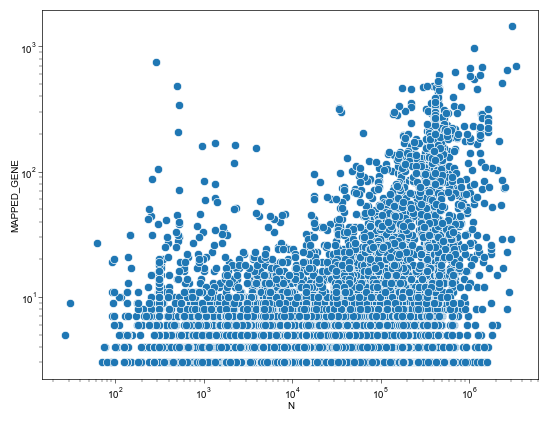

In [43]:
sns.scatterplot(study_info, x='N', y='MAPPED_GENE')
plt.xscale('log')
plt.yscale('log')

In [44]:
sns.scatterplot(shared_cv, x='N', y='MAPPED_GENE')
plt.xscale('log')
plt.yscale('log')

NameError: name 'shared_cv' is not defined

In [45]:
def select_top_gwas_study(gwas_data, trait, study_info, keep_studies, exclude=['UKB', 'UKBB']):
    study_info['StudyTrait'] = study_info['STUDY ACCESSION'] + '_' + study_info['TRAIT_CODE_CLEAN']
    study_subset = study_info[study_info['STUDY ACCESSION'].isin(gwas_data[(gwas_data.TRAIT_CODE_CLEAN==trait) & (gwas_data['STUDY ACCESSION'].isin(keep_studies))]['STUDY ACCESSION'])]
    study_subset = study_subset.dropna(subset=['N'])
    #print(len(study_subset))
    
    if len(study_subset) > 1:
        study_subset = prioritize_by_cosine(study_subset, th=0.8)
        if len(study_subset) > 1:
            study_subset = prioritize_by_cohort(study_subset, exclude=exclude)
            if len(study_subset) > 1:
                study_subset = prioritize_by_n(study_subset)
                if len(study_subset) > 1:
                    study_subset = prioritize_by_sumstats(study_subset)
                    if len(study_subset) > 1:
                        study_subset = prioritize_by_cohort(study_subset)
                        if len(study_subset) > 1:
                            return select_top_n(study_subset)
                        else:
                            return study_subset['STUDY ACCESSION'].values[0]
                    else:
                        return study_subset['STUDY ACCESSION'].values[0]
                else:
                    return study_subset['STUDY ACCESSION'].values[0]
            else:
                return study_subset['STUDY ACCESSION'].values[0]
        else:
            return study_subset['STUDY ACCESSION'].values[0]
    elif len(study_subset) == 0:
        #print('No studies with N information')
        return np.nan
    else:
        return study_subset['STUDY ACCESSION'].values[0]


def prioritize_by_cosine(study_subset, th=0.8):
    while th > -0.1:
        high_cosine = study_subset[study_subset.Cosine>th]
        if len(high_cosine) >= 1:
            non_found = False
            return high_cosine
        else:
            th -= 0.1
    return high_cosine
    
    
def prioritize_by_sumstats(study_subset):
    with_sumstats = study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]
    if len(with_sumstats) == 0:
        return study_subset
    else:
        return with_sumstats

def prioritize_by_n(study_subset):
    high_n = study_subset[study_subset.N > 100000]
    if len(high_n) == 0:
        high_n = study_subset[study_subset.N > 50000]
        if len(high_n) == 0:
            return study_subset
        else:
            return high_n
    else:
        return high_n
    

def prioritize_by_cohort(study_subset, exclude=[]):
    if len(exclude) > 0:
        excluded = study_subset[~study_subset.COHORT.isin(exclude)]
        if len(excluded) > 0:
            return excluded
        else:
            return study_subset
    else:
        with_cohort = study_subset[~study_subset.COHORT.isna()]
        if len(with_cohort) == 0:
            return study_subset
        else:
            return with_cohort
        

def select_top_n(study_subset):
    return study_subset.sort_values('N', ascending=False)['STUDY ACCESSION'].values[0]


def prioritize_gwas_studies(gwas_data, trait, keep_studies, study_info, n=5, verbose=True):
    study_info['StudyTrait'] = study_info['STUDY ACCESSION'] + '_' + study_info['TRAIT_CODE']
    study_subset = study_info[study_info['STUDY ACCESSION'].isin(gwas_data[gwas_data.TRAIT_CODE==trait]['STUDY ACCESSION'])]
    
    study_subset = study_subset[study_subset['StudyTrait'].isin(keep_studies)]
    initial_count = len(study_subset)
    study_subset = study_subset.dropna(subset=['N'])

    out_studies = []
    if len(study_subset) > n:
        # remove those with background traits
        study_subset = study_subset[study_subset['MAPPED BACKGROUND TRAIT URI'].isna()]
        if len(study_subset) > n:
            #priortize those with summary stats available
            if len(study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]) > n:
                study_subset = study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]
            else:
                out_studies += list(study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()].drop_duplicates(subset=['COHORTID'])['STUDY ACCESSION'].values)
                n -= len(out_studies)
                study_subset = study_subset[study_subset['SUMMARY STATS LOCATION'].isna()]
            # then sort by population size.
            study_subset = study_subset.sort_values(['N', 'ASSOCIATION COUNT'], ascending=False)
            # then select by cohort
            has_cohort = study_subset[~study_subset.COHORT.isna()]
            keep_cohort = has_cohort.drop_duplicates(subset='COHORTID', keep='first').drop_duplicates(subset='DATE ADDED TO CATALOG')
            if len(keep_cohort) >= n:
                out_studies += list(keep_cohort['STUDY ACCESSION'].values[0:n])
            else:
                out_studies += list(keep_cohort['STUDY ACCESSION'].values)
                n = n - len(keep_cohort)
                out_studies += list(study_subset[study_subset.COHORT.isna()]['STUDY ACCESSION'].values[0:n])
        else:
            out_studies += list(study_subset['STUDY ACCESSION'].values)
    else:
        study_subset = study_subset.sort_values(['N', 'ASSOCIATION COUNT'], ascending=False)
        keep_cohort = study_subset.drop_duplicates(subset='COHORTID', keep='first').drop_duplicates(subset='DATE ADDED TO CATALOG')
        out_studies += list(keep_cohort['STUDY ACCESSION'].values)
    if verbose:
        print(trait, initial_count, len(out_studies))
    return out_studies



Without UKB filtering

In [46]:
multi_select_cv = {}
for t in tqdm(study_info['TRAIT_CODE_CLEAN'].unique()):
    t.replace(':', '_')
    
    multi_select_cv[t] = select_top_gwas_study(gwas_genes, t, study_info, exclude=[],
                                               keep_studies=study_info['STUDY ACCESSION'].values)

100%|██████████| 2339/2339 [01:09<00:00, 33.83it/s]


In [47]:
study_info.shape

(7583, 34)

In [48]:
1965+373

2338

In [49]:
cv_start = len([ x for x in multi_select_cv.values() if isinstance(x, str) ])
cv_start

2338

In [50]:
multi_select_cv['MONDO_0004975']

'GCST90444373'

With UKB filtering

## Shared_studies

In [47]:
# export all study info

In [51]:
cv_study_info = study_info.copy()

In [52]:
cv_study_info.loc[:, ('PUBMED ID', 'DATE', 'STUDY ACCESSION', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE', 'ASSOCIATION COUNT',
                     'COHORT', 'MAPPED_TRAIT_CLEAN', 'TRAIT_CODE_CLEAN', 'N', 'MAPPED_GENE', 'Cosine', 
                      'StudyTrait')].to_csv(os.path.join(datadir, 'inputs/cv_all_study_info.txt'), sep='\t', index=False)

In [53]:
rv_study_info.columns

Index(['Reported Trait', 'Trait Label', 'Trait Ontology id', 'PMID', 'COHORT',
       'N', 'Ancestry', 'Classification', 'Notes', 'rv_idx', 'Trait', 'Mapped',
       'TraitExp', 'MappedExp', 'MAPPED_TRAIT_CLEAN', 'TRAIT_CODE_CLEAN',
       'GeneCount', 'MappedCleanExp', 'Cosine'],
      dtype='object')

In [54]:
rv_study_info.loc[:, ('Reported Trait', 'PMID', 'COHORT', 'N', 'Ancestry', 'Classification', 'MAPPED_TRAIT_CLEAN', 
                      'TRAIT_CODE_CLEAN', 'GeneCount', 'Cosine')].to_csv(os.path.join(datadir, 'inputs/rv_all_study_info.txt'), 
                                                                         sep='\t', index=False)

### Shared RV without UKB filtering

In [55]:
len(shared_studies)

NameError: name 'shared_studies' is not defined

In [56]:
shared_studies = list(set(multi_select_cv.keys()).intersection(multi_select_rv.keys()))
shared_rv = pd.DataFrame({'TRAIT_CODE_CLEAN':shared_studies, 'PMID': [multi_select_rv[x] for x in shared_studies]}, index=shared_studies)
shared_rv = shared_rv.dropna()
shared_rv['PMID'] = shared_rv.PMID.astype(int)
rv_study_info['PMID'] = rv_study_info.PMID.astype(int)

In [57]:
shared_rv = rv_study_info.merge(shared_rv, on=['PMID', 'TRAIT_CODE_CLEAN'], 
                    how='inner').drop_duplicates().sort_values(by='Cosine', ascending=False)
shared_rv = shared_rv.drop_duplicates(subset=['PMID', 'TRAIT_CODE_CLEAN'])
#shared_rv.to_csv(os.path.join(datadir, 'RAVAR', 'ravar_gwascat_study_info_Mar28.txt'), sep='\t', index=False)

### Shared CV without UKB filtering

In [58]:
shared_cv = pd.DataFrame({'STUDY ACCESSION': multi_select_cv}).reset_index().rename(columns={'index':'TRAIT_CODE_CLEAN'}).dropna()
shared_cv = shared_cv[shared_cv.TRAIT_CODE_CLEAN.isin(shared_studies)]
shared_cv = study_info.merge(shared_cv, on=['STUDY ACCESSION', 'TRAIT_CODE_CLEAN'], 
                             how='inner').drop_duplicates().sort_values(by='Cosine', ascending=False)
#shared_cv.to_csv(os.path.join(datadir, 'GWASCatalog', 'gwascat_ravar_study_Mar28.txt'), sep='\t', index=False)

### Combined without UKB filtering

In [60]:
a = shared_cv.loc[:, ('DISEASE/TRAIT', 'STUDY ACCESSION', 'COHORT', 'TRAIT_CODE_CLEAN', 'MAPPED_TRAIT_CLEAN', 'N', 'Cosine', 'TraitExp', 'MappedCleanExp', 'PUBMED ID')]
b = shared_rv.loc[:, ('Reported Trait', 'Trait Label', 'PMID', 'COHORT', 'N', 'Classification', 'Cosine', 'MAPPED_TRAIT_CLEAN', 'TRAIT_CODE_CLEAN','TraitExp', 'MappedCleanExp' )]
shared_df = a.merge(b, on=['TRAIT_CODE_CLEAN'], how='inner', suffixes=['_C', '_R'])
shared_cv_trait = model.encode(shared_df['TraitExp_C'], batch_size=32)
shared_rv_trait = model.encode(shared_df['TraitExp_R'], batch_size=32)
cosines = cosine_similarity(shared_cv_trait, shared_rv_trait)
shared_df = shared_df.assign(CosineRC=[cosines[i,i] for i in range(len(shared_cv_trait))])
#shared_df.loc[:, ('Reported Trait', 'DISEASE/TRAIT','MAPPED_TRAIT_CLEAN_C', 'MAPPED_TRAIT_CLEAN_R', 'Cosine_R', 'Cosine_C', 
#                  'CosineRC')].to_csv('/cellar/users/snwright/Data/Transfer/RVC/data/check_trait_pairs.txt', sep='\t')


In [61]:
shared_df.CosineRC.describe()

count    394.000000
mean       0.855056
std        0.178117
min        0.052196
25%        0.791719
50%        0.923691
75%        1.000000
max        1.000000
Name: CosineRC, dtype: float64

In [329]:
raise NotImplementedError('Manual curation needed')

NotImplementedError: Manual curation needed

In [62]:
clean_shared_df.head()

NameError: name 'clean_shared_df' is not defined

In [66]:
clean_shared_df = pd.read_csv('/cellar/users/snwright/Data/Transfer/RVC/data/RV Study Info - Shared Traits6.tsv', sep='\t', index_col=0)
final_shared_df = shared_df.merge(clean_shared_df.loc[clean_shared_df.Keep==1, ('Reported Trait', 'DISEASE/TRAIT', 'Domain', 'trait_type')], 
                       on=['Reported Trait', 'DISEASE/TRAIT'], how='inner', suffixes=['', 'Final'])
assert len(final_shared_df) == clean_shared_df.Keep.sum(), 'Manual file does not match'
final_shared_df['StudyC'] = final_shared_df['STUDY ACCESSION'] + '_' + final_shared_df['TRAIT_CODE_CLEAN']
final_shared_df['StudyR'] = final_shared_df['PMID'].astype(str) + '_' + final_shared_df['TRAIT_CODE_CLEAN']
final_shared_df.drop_duplicates(subset='TRAIT_CODE_CLEAN').to_csv('/cellar/users/snwright/Data/RareCommon/inputs/March_2025/shared_traits_df_Mar28.tsv', sep='\t', index=False)

In [65]:
final_shared_df.head()

,DISEASE/TRAIT,STUDY ACCESSION,COHORT_C,TRAIT_CODE_CLEAN,MAPPED_TRAIT_CLEAN_C,N_C,Cosine_C,TraitExp_C,MappedCleanExp_C,PUBMED ID,...,Classification,Cosine_R,MAPPED_TRAIT_CLEAN_R,TraitExp_R,MappedCleanExp_R,CosineRC,Domain,trait_type,StudyC,StudyR
0,Proteinuria,GCST90250893,other,HP_0000093,proteinuria,1078.0,1.0,Proteinuria,proteinuria,36399516,...,Population CC,0.871416,proteinuria,isolated proteinuria,proteinuria,0.871416,Renal,CC,GCST90250893_HP_0000093,34375979_HP_0000093
1,Neutrophil count,GCST90002355,Airwave|BBJ|BioME|BioME|BioME|CaPS|Estonia|Est...,EFO_0004833,neutrophil count,627215.0,1.0,Neutrophil count,neutrophil count,32888493,...,Population Q,1.000000,neutrophil count,neutrophil count,neutrophil count,1.000000,Immunological,Q,GCST90002355_EFO_0004833,28089252_EFO_0004833
2,Autism spectrum disorder,GCST007556,NaN,EFO_0003756,autism spectrum disorder,46350.0,1.0,Autism spectrum disorder,autism spectrum disorder,30804558,...,Ascertained CC,1.000000,autism spectrum disorder,autism spectrum disorder,autism spectrum disorder,1.000000,Psychiatric,CC,GCST007556_EFO_0003756,35982160_EFO_0003756
3,Pulmonary tuberculosis,GCST90275073,NR,EFO_1000049,pulmonary tuberculosis,2786.0,1.0,Pulmonary tuberculosis,pulmonary tuberculosis,37009413,...,Population CC/Q,0.867460,pulmonary tuberculosis,tuberculosis (tb,pulmonary tuberculosis,0.867460,Infection,CC,GCST90275073_EFO_1000049,34375979_EFO_1000049
4,Pulmonary embolism,GCST90278093,other,EFO_0003827,pulmonary embolism,9475.0,1.0,Pulmonary embolism,pulmonary embolism,37076872,...,Population CC,1.000000,pulmonary embolism,pulmonary embolism,pulmonary embolism,1.000000,Cardiovascular,CC,GCST90278093_EFO_0003827,34375979_EFO_0003827


## Figures

In [62]:
final_count = final_shared_df.TRAIT_CODE_CLEAN.nunique()

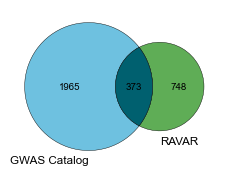

In [352]:
plt.rcParams.update({'font.size': 7})
_ = plt.figure(figsize=(3,2))
v = venn2(subsets=(cv_start-final_count, rv_start-final_count, final_count), set_labels=( 'GWAS Catalog','RAVAR'))
v.get_patch_by_id('10').set_color('#6ec1e0')
v.get_patch_by_id('01').set_color('#5fad56')
v.get_patch_by_id('11').set_color('#00606f')
for patch in ['01', '10', '11']:
    v.get_patch_by_id(patch).set_alpha(1)
    v.get_patch_by_id(patch).set_ec('black')
    v.get_patch_by_id(patch).set_lw(0.3)
plt.savefig(os.path.join(figdir, 'trait_overlap_venn2.svg'), dpi=400, bbox_inches='tight')

In [416]:
187+186

373

In [418]:
final_shared_df.median(numeric_only=True)

N_C          1.360160e+05
Cosine_C     9.429650e-01
PUBMED ID    3.637603e+07
PMID         3.437598e+07
N_R          2.093190e+05
Cosine_R     9.999998e-01
CosineRC     9.294033e-01
dtype: float64

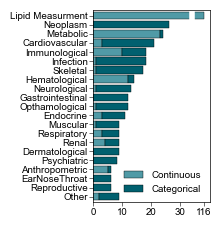

In [355]:
domains = final_shared_df.Domain.value_counts().reset_index()
domain_plot_values = domains[domains['count']>=5].Domain.values
domains = final_shared_df[final_shared_df.trait_type=='Q'].Domain.value_counts().reset_index()
domains_plot = domains[domains.Domain.isin(domain_plot_values)]
other=domains[~domains.Domain.isin(domain_plot_values)]['count'].sum()
domain_dict =domains_plot.set_index('Domain')['count'].to_dict()
domain_dict['Other'] = other

domains = final_shared_df[final_shared_df.trait_type=='CC'].Domain.value_counts().reset_index()
domains_plot2 = domains[domains.Domain.isin(domain_plot_values)]
other2=domains[~domains.Domain.isin(domain_plot_values)]['count'].sum()
domain_dict2 =domains_plot2.set_index('Domain')['count'].to_dict()
domain_dict2['Other'] = other2

_ = plt.figure(figsize=(1.5, 2.5))
plot_df = pd.DataFrame({'Continuous': domain_dict, 'Categorical': domain_dict2}).iloc[::-1]
plot_df['sum'] = np.nansum(plot_df, axis=1)
plot_df.at['Other', 'sum'] = 0
plot_df = plot_df.sort_values('sum')

lipid = plot_df.at['Lipid Measurment', 'Continuous']
plot_df.at['Lipid Measurment', 'Continuous'] = 38

plot_df.drop(columns='sum').plot(kind='barh', stacked=True, ax=plt.gca(),edgecolor='black', linewidth=0.3, width=0.8,
                                                                              color=[ '#509AA6', '#00606f',])
plt.vlines(x=34, ymin=-18.5, ymax=20.5,color='white', linewidth=4)

plt.xticks([0, 10, 20, 30, 38], labels=[0,10,20,30,int(lipid)])
plt.xlim(0, 40)
plt.savefig(os.path.join(figdir, 'GCat_input_trait_types.svg'), bbox_inches='tight')

,Continuous,Categorical
Other,2.0,7.0
Reproductive,NaN,6.0
EarNoseThroat,NaN,6.0
Anthropometric,5.0,1.0
Psychiatric,NaN,8.0
Dermatological,NaN,9.0
Renal,4.0,5.0
Respiratory,3.0,6.0
Muscular,1.0,8.0
Endocrine,3.0,8.0


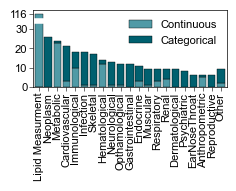

In [347]:
domains = final_shared_df.Domain.value_counts().reset_index()
domain_plot_values = domains[domains['count']>=5].Domain.values
domains = final_shared_df[final_shared_df.trait_type=='Q'].Domain.value_counts().reset_index()
domains_plot = domains[domains.Domain.isin(domain_plot_values)]
other=domains[~domains.Domain.isin(domain_plot_values)]['count'].sum()
domain_dict =domains_plot.set_index('Domain')['count'].to_dict()
domain_dict['Other'] = other

domains = final_shared_df[final_shared_df.trait_type=='CC'].Domain.value_counts().reset_index()
domains_plot2 = domains[domains.Domain.isin(domain_plot_values)]
other2=domains[~domains.Domain.isin(domain_plot_values)]['count'].sum()
domain_dict2 =domains_plot2.set_index('Domain')['count'].to_dict()
domain_dict2['Other'] = other2

_ = plt.figure(figsize=(2.5, 1))
plot_df = pd.DataFrame({'Continuous': domain_dict, 'Categorical': domain_dict2}).iloc[::-1]
plot_df['sum'] = np.nansum(plot_df, axis=1)
plot_df.at['Other', 'sum'] = 0
plot_df = plot_df.sort_values('sum', ascending=False)
lipid = plot_df.at['Lipid Measurment', 'Continuous']
plot_df.at['Lipid Measurment', 'Continuous'] = 38
plot_df.drop(columns='sum').plot(kind='bar', stacked=True, ax=plt.gca(),edgecolor='black', linewidth=0.3, width=0.8,
                                                                              color=[ '#509AA6', '#00606f',])


plt.hlines(y=34, xmin=-18.5, xmax=20.5,color='white', linewidth=4)
plt.ylim(0, 40)
plt.yticks([0, 10, 20, 30, 38], labels=[0,10,20,30,int(lipid)])
plt.savefig(os.path.join(figdir, 'GCat_input_trait_types_vertical.svg'), bbox_inches='tight')

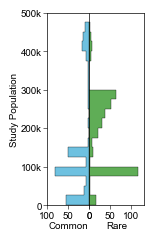

In [356]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(1.25, 2.5), sharey=True, 
                             gridspec_kw={'wspace':0, 'width_ratios':[100,130]})
bins=[x*25000 for x in range(0,  20)]
sns.histplot(y= final_shared_df.N_R, bins=bins, kde=False, element='step', ax=ax2, color='#5fad56', alpha=1, edgecolor='black')
sns.histplot(y= final_shared_df.N_C, bins=bins, kde=False, element='step', ax=ax1,color='#6ec1e0' , alpha=1, edgecolor='black')
ax1.invert_xaxis()
ax1.set_xlim(100, 0)
ax2.set_xlim(0, 130)
ax1.set_ylim(0, 500000)
_ = ax1.set_yticks([x*100000 for x in range(6)], labels=[0, '100k', '200k', '300k', '400k', '500k'])
ax1.set_ylabel('Study Population')
ax1.set_xticks([100, 50, 0])
ax2.set_xticks([0, 50, 100])
ax1.set_xlabel('Common')
ax2.set_xlabel('Rare')
ax2.tick_params(axis='y', size=0)

plt.savefig(os.path.join(figdir, 'population_size_histograms_gcat.svg'), bbox_inches='tight')

In [76]:
final_shared_df.head(1).T

,0
DISEASE/TRAIT,Proteinuria
STUDY ACCESSION,GCST90250893
COHORT_C,other
TRAIT_CODE_CLEAN,HP_0000093
MAPPED_TRAIT_CLEAN_C,proteinuria
N_C,1078.0
Cosine_C,1.0
TraitExp_C,Proteinuria
MappedCleanExp_C,proteinuria
PUBMED ID,36399516


In [77]:
final_shared_df.loc[:, ('N_R', 'N_C', 'Domain', 'trait_type', 'DISEASE/TRAIT', 'StudyC', 'StudyR', 'Cosine_C', 'Cosine_R', 'COHORT_C', 'COHORT_R')].to_csv(os.path.join(datadir, 'inputs', 'gcat_input_features_Mar28.tsv'), sep='\t', index=False)

## Create Input files

In [423]:
ravar_genes['P-value'].describe()

count    6.037400e+04
mean     1.798475e-05
std      2.804771e-05
min      0.000000e+00
25%      2.450000e-15
50%      4.150000e-09
75%      3.200000e-05
max      9.940000e-05
Name: P-value, dtype: float64

In [75]:
inputdir = '/cellar/users/snwright/Data/RareCommon/inputs/March_2025'
with open(os.path.join(inputdir, 'common_Mar28.traitlist'), 'w') as f:
    f.writelines('\n'.join(final_shared_df.StudyC.values)+'\n')
with open(os.path.join(inputdir, 'rare_Mar28.traitlist'), 'w') as f:
    f.writelines('\n'.join(final_shared_df.StudyR.values)+'\n')

In [80]:
final_shared_df.shape

(373, 24)

In [83]:
# check that there don't seem to be too many unique values outside the primary indexers
gwas_genes[gwas_genes.TRAIT_CODE_CLEAN.isin(final_shared_df.TRAIT_CODE_CLEAN)  &
          gwas_genes['STUDY ACCESSION'].isin(final_shared_df['STUDY ACCESSION']) &
          gwas_genes['DISEASE/TRAIT'].isin(final_shared_df['DISEASE/TRAIT'])].nunique()

PUBMEDID                        162
DATE_x                          155
DISEASE/TRAIT                   373
MAPPED_GENE                    5318
SNP_GENE_IDS                   5318
INTERGENIC                        1
P-VALUE                         958
OR or BETA                     8578
MAPPED_TRAIT                    370
MAPPED_TRAIT_URI                370
STUDY ACCESSION                 373
logp                            952
from                           5318
Entrez                         5318
INITIAL SAMPLE SIZE             251
DATE ADDED TO CATALOG           154
PUBMED ID                       162
FIRST AUTHOR                    158
DATE_y                          155
JOURNAL                          73
LINK                            162
STUDY                           162
REPLICATION SAMPLE SIZE          43
PLATFORM [SNPS PASSING QC]      234
GENOTYPING TECHNOLOGY             2
SUBMISSION DATE                   0
STATISTICAL MODEL                 0
BACKGROUND TRAIT            

In [84]:
c_size= []
for i, t in tqdm(enumerate(final_shared_df.TRAIT_CODE_CLEAN.values)):
    accession = final_shared_df.iloc[i]['STUDY ACCESSION']
    trait = final_shared_df.iloc[i]['DISEASE/TRAIT']
    study_genes = gwas_genes[(gwas_genes.TRAIT_CODE_CLEAN==t) & (gwas_genes['STUDY ACCESSION']==accession) & (gwas_genes['DISEASE/TRAIT']==trait)]
    study_genes = study_genes.sort_values('logp', ascending=False)
    study_genes = study_genes.drop_duplicates(subset='Entrez')
    study_out = study_genes.loc[:, ('Entrez', 'MAPPED_GENE', 'P-VALUE', 'OR or BETA' )]
    study_out.columns = ['Entrez', 'Gene Symbol', 'P-value', 'Beta']
    c_size.append(len(study_out))
    study_out.to_csv(os.path.join(inputdir, accession+'_'+t+'_CV.txt'), sep='\t', index=False)

373it [00:23, 16.17it/s]


In [85]:
r_size=[]
for i, t in tqdm(enumerate(final_shared_df.TRAIT_CODE_CLEAN.values)):
    pmid = final_shared_df.iloc[i]['PMID']
    trait = final_shared_df.iloc[i]['Reported Trait']
    study_genes = ravar_genes[(ravar_genes.TRAIT_CODE_CLEAN==t) & (ravar_genes['PMID']==pmid) & (ravar_genes['Reported Trait']==trait)]
    study_genes = study_genes.sort_values('P-value', ascending=True)
    study_genes = study_genes.drop_duplicates(subset='Entrez')
    study_out = study_genes.loc[:, ('Entrez', 'Gene Symbol','Ensembl ID',  'P-value')]
    r_size.append(len(study_out))
    study_out.to_csv(os.path.join(inputdir, str(int(pmid))+'_'+t+'_RV.txt'), sep='\t', index=False)

373it [00:04, 81.27it/s]


## Identify repeats


What should be prioritized:
* Cosine similarity (set minimums, not realistic to manually check)
* Different PMID
* Different COHORT
* Study size

In [68]:
def select_top_gwas_study(gwas_data, trait, study_info, keep_studies, exclude=['UKB', 'UKBB']):
    study_info['StudyTrait'] = study_info['STUDY ACCESSION'] + '_' + study_info['TRAIT_CODE_CLEAN']
    study_subset = study_info[study_info['STUDY ACCESSION'].isin(gwas_data[(gwas_data.TRAIT_CODE_CLEAN==trait) & (gwas_data['STUDY ACCESSION'].isin(keep_studies))]['STUDY ACCESSION'])]
    study_subset = study_subset.dropna(subset=['N'])
    #print(len(study_subset))
    
    if len(study_subset) > 1:
        study_subset = prioritize_by_cosine(study_subset, th=0.8)
        if len(study_subset) > 1:
            study_subset = prioritize_by_cohort(study_subset, exclude=exclude)
            if len(study_subset) > 1:
                study_subset = prioritize_by_n(study_subset)
                if len(study_subset) > 1:
                    study_subset = prioritize_by_sumstats(study_subset)
                    if len(study_subset) > 1:
                        study_subset = prioritize_by_cohort(study_subset)
                        if len(study_subset) > 1:
                            return select_top_n(study_subset)
                        else:
                            return study_subset['STUDY ACCESSION'].values[0]
                    else:
                        return study_subset['STUDY ACCESSION'].values[0]
                else:
                    return study_subset['STUDY ACCESSION'].values[0]
            else:
                return study_subset['STUDY ACCESSION'].values[0]
        else:
            return study_subset['STUDY ACCESSION'].values[0]
    elif len(study_subset) == 0:
        #print('No studies with N information')
        return np.nan
    else:
        return study_subset['STUDY ACCESSION'].values[0]


def prioritize_by_cosine(study_subset, th=0.8):
    while th > -0.1:
        high_cosine = study_subset[study_subset.Cosine>th]
        if len(high_cosine) >= 1:
            non_found = False
            return high_cosine
        else:
            th -= 0.1
    return high_cosine
    
    
def prioritize_by_sumstats(study_subset):
    with_sumstats = study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]
    if len(with_sumstats) == 0:
        return study_subset
    else:
        return with_sumstats

def prioritize_by_n(study_subset):
    high_n = study_subset[study_subset.N > 100000]
    if len(high_n) == 0:
        high_n = study_subset[study_subset.N > 50000]
        if len(high_n) == 0:
            return study_subset
        else:
            return high_n
    else:
        return high_n
    

def prioritize_by_cohort(study_subset, exclude=[]):
    if len(exclude) > 0:
        excluded = study_subset[~study_subset.COHORT.isin(exclude)]
        if len(excluded) > 0:
            return excluded
        else:
            return study_subset
    else:
        with_cohort = study_subset[~study_subset.COHORT.isna()]
        if len(with_cohort) == 0:
            return study_subset
        else:
            return with_cohort
        

def select_top_n(study_subset):
    return study_subset.sort_values('N', ascending=False)['STUDY ACCESSION'].values[0]


def prioritize_gwas_studies(gwas_data, trait, keep_studies, study_info, n=5, verbose=True):
    study_info['StudyTrait'] = study_info['STUDY ACCESSION'] + '_' + study_info['TRAIT_CODE']
    study_subset = study_info[study_info['STUDY ACCESSION'].isin(gwas_data[gwas_data.TRAIT_CODE==trait]['STUDY ACCESSION'])]
    
    study_subset = study_subset[study_subset['StudyTrait'].isin(keep_studies)]
    initial_count = len(study_subset)
    study_subset = study_subset.dropna(subset=['N'])

    out_studies = []
    if len(study_subset) > n:
        # remove those with background traits
        study_subset = study_subset[study_subset['MAPPED BACKGROUND TRAIT URI'].isna()]
        if len(study_subset) > n:
            #priortize those with summary stats available
            if len(study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]) > n:
                study_subset = study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]
            else:
                out_studies += list(study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()].drop_duplicates(subset=['COHORTID'])['STUDY ACCESSION'].values)
                n -= len(out_studies)
                study_subset = study_subset[study_subset['SUMMARY STATS LOCATION'].isna()]
            # then sort by population size.
            study_subset = study_subset.sort_values(['N', 'ASSOCIATION COUNT'], ascending=False)
            # then select by cohort
            has_cohort = study_subset[~study_subset.COHORT.isna()]
            keep_cohort = has_cohort.drop_duplicates(subset='COHORTID', keep='first').drop_duplicates(subset='DATE ADDED TO CATALOG')
            if len(keep_cohort) >= n:
                out_studies += list(keep_cohort['STUDY ACCESSION'].values[0:n])
            else:
                out_studies += list(keep_cohort['STUDY ACCESSION'].values)
                n = n - len(keep_cohort)
                out_studies += list(study_subset[study_subset.COHORT.isna()]['STUDY ACCESSION'].values[0:n])
        else:
            out_studies += list(study_subset['STUDY ACCESSION'].values)
    else:
        study_subset = study_subset.sort_values(['N', 'ASSOCIATION COUNT'], ascending=False)
        keep_cohort = study_subset.drop_duplicates(subset='COHORTID', keep='first').drop_duplicates(subset='DATE ADDED TO CATALOG')
        out_studies += list(keep_cohort['STUDY ACCESSION'].values)
    if verbose:
        print(trait, initial_count, len(out_studies))
    return out_studies



### CV

In [69]:
# remove already used studies
def identify_trait_repeats_cv(trait, study_info, exclude_study_info=('pmid', 'study acc', 'dis/t'), n=4, cosine_min=0.7):
    trait_info = study_info[study_info.TRAIT_CODE_CLEAN==trait]
    # identify the info of the already selected study:
    cohort = trait_info[(trait_info['STUDY ACCESSION'] == exclude_study_info[1]) &
                       (trait_info['DISEASE/TRAIT'] == exclude_study_info[2]) &
                       (trait_info['PUBMED ID'] == exclude_study_info[0])].COHORT.values[0]
    # drop based on cosine similarities
    trait_info = trait_info[trait_info.Cosine >= cosine_min]
    
    # first drop by PMID
    trait_info = trait_info[~trait_info['PUBMED ID'].isin([exclude_study_info[0]])]
    
    # now prioritize remaining studies
    if len(trait_info) == 0:
        return np.nan
    elif len(trait_info) <= n:
        return [x for x in zip(trait_info['STUDY ACCESSION'].values, trait_info['DISEASE/TRAIT'].values)]
    else:
        # still too many studies
        remove_cohort = trait_info[trait_info.COHORT!=cohort].sort_values(by=['Cosine', 'N'], ascending=False).drop_duplicates(subset='COHORT')
        out_studies = []
        out_studies += [x for x in zip(remove_cohort['STUDY ACCESSION'].values, remove_cohort['DISEASE/TRAIT'].values)]
        if len(out_studies) == n:
            return out_studies
        elif len(out_studies) >= n:
            return out_studies[0:n]
        else:
            while len(out_studies) < n:
            
                remaining_n = n - len(out_studies)
                remaining_studies = trait_info[~trait_info['STUDY ACCESSION'].isin([x[0] for x in out_studies])].sort_values(by=['Cosine', 'N'], ascending=False)
                if len(remaining_studies.drop_duplicates(subset='COHORT')) > remaining_n:
                    out_studies += [x for x in zip(remaining_studies.drop_duplicates(subset='COHORT')['STUDY ACCESSION'].values[0:remaining_n],
                                                  remaining_studies.drop_duplicates(subset='COHORT')['DISEASE/TRAIT'].values[0:remaining_n])]
                    return out_studies
                else:
                    out_studies += [x for x in zip(remaining_studies.drop_duplicates(subset='COHORT')['STUDY ACCESSION'].values,
                                                  remaining_studies.drop_duplicates(subset='COHORT')['DISEASE/TRAIT'].values)]
            return out_studies
                
    
    

In [70]:
cv_repeats = {}
for t in tqdm(final_shared_df['TRAIT_CODE_CLEAN'].unique()):
    t.replace(':', '_')
    pmid = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('PUBMED ID')].values[0]
    acc = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('STUDY ACCESSION')].values[0]
    dis = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('DISEASE/TRAIT')].values[0]
    cv_repeats[t] = identify_trait_repeats_cv( t, study_info, exclude_study_info=(pmid, acc, dis),n=4)

100%|██████████| 373/373 [00:01<00:00, 340.79it/s]


In [71]:
# remove already used studies
def identify_trait_repeats_rv(trait, study_info, exclude_study_info=('pmid', 'dis/t'), n=4, cosine_min=0.7):
    trait_info = study_info[study_info.TRAIT_CODE_CLEAN==trait]
    # identify the info of the already selected study:
    cohort = trait_info[(trait_info['Reported Trait'] == exclude_study_info[1]) &
                       (trait_info['PMID'] == exclude_study_info[0])].COHORT.values[0]
    # drop based on cosine similarities
    trait_info = trait_info[trait_info.Cosine >= cosine_min]
    
    # first drop by PMID
    trait_info = trait_info[~trait_info['PMID'].isin([exclude_study_info[0]])]
    
    # now prioritize remaining studies
    if len(trait_info) == 0:
        return np.nan
    elif len(trait_info) <= n:
        out_info = trait_info.sort_values(by=['Cosine', 'N'], ascending=False).drop_duplicates(subset='PMID')
        return [x for x in zip(out_info['PMID'].values, out_info['Reported Trait'])]
    else:
        # still too many studies
        remove_cohort = trait_info[trait_info.COHORT!=cohort].sort_values(by=['Cosine', 'N'], ascending=False).drop_duplicates(subset='COHORT').drop_duplicates(subset='PMID')
        out_studies = []
        out_studies += [x for x in zip(remove_cohort['PMID'].values, remove_cohort['Reported Trait'])]
        if len(out_studies) == n:
            return out_studies
        elif len(out_studies) >= n:
            return out_studies[0:n]
        else:
            while len(out_studies) < n:
            
                remaining_n = n - len(out_studies)
                remaining_studies = trait_info[~trait_info['PMID'].isin([x[0] for x in out_studies])].sort_values(by=['Cosine', 'N'], ascending=False).drop_duplicates(subset='PMID')
                if len(remaining_studies) == 0:
                    return out_studies
                if len(remaining_studies.drop_duplicates(subset='COHORT')) > remaining_n:
                    out_studies += [x for x in zip(remaining_studies.drop_duplicates(subset='COHORT')['PMID'].values[0:remaining_n],
                                   remaining_studies.drop_duplicates(subset='COHORT')['Reported Trait'].values[0:remaining_n])]
                    return out_studies
                else:
                    out_studies += [x for x in zip(remaining_studies.drop_duplicates(subset='COHORT')['PMID'].values,
                                   remaining_studies.drop_duplicates(subset='COHORT')['Reported Trait'].values)]
            return out_studies
    
    

In [72]:
rv_repeats = {}
for t in tqdm(final_shared_df['TRAIT_CODE_CLEAN'].unique()):
    t.replace(':', '_')
    pmid = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('PMID')].values[0]
    dis = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('Reported Trait')].values[0]
    rv_repeats[t] = identify_trait_repeats_rv( t, rv_study_info, exclude_study_info=(pmid,dis),n=4)

100%|██████████| 373/373 [00:00<00:00, 495.80it/s]


### Create genesets

In [283]:
for i, t in tqdm(enumerate(cv_repeats.keys())):
    if isinstance(cv_repeats[t], list):
        for acc, dis in cv_repeats[t]:
            study_genes = gwas_genes[(gwas_genes.TRAIT_CODE_CLEAN==t) & 
                                     (gwas_genes['STUDY ACCESSION']==acc) & 
                                     (gwas_genes['DISEASE/TRAIT']==dis)]
            study_genes = study_genes.sort_values('P-VALUE', ascending=True)
            study_genes = study_genes.drop_duplicates(subset='Entrez')
            study_out = study_genes.loc[:, ('Entrez', 'MAPPED_GENE', 'P-VALUE', 'OR or BETA' )]
            study_out.columns = ['Entrez', 'Gene Symbol', 'P-value', 'Beta']
            study_out.to_csv(os.path.join(inputdir, acc+'_'+t+'_CV.txt'), sep='\t', index=False)

373it [00:34, 10.89it/s]


In [284]:
for i, t in tqdm(enumerate(rv_repeats.keys())):
    if isinstance(rv_repeats[t], list):
        for acc, dis in rv_repeats[t]:  
            study_genes = ravar_genes[(ravar_genes.TRAIT_CODE_CLEAN==t) & 
                                      (ravar_genes['PMID']==acc) & 
                                      (ravar_genes['Reported Trait']==dis)]

            study_genes = study_genes.sort_values('P-value', ascending=True)
            study_genes = study_genes.drop_duplicates(subset='Entrez')
            study_out = study_genes.loc[:, ('Entrez', 'Gene Symbol','Ensembl ID',  'P-value')]
            study_out.to_csv(os.path.join(inputdir, str(int(acc))+'_'+t+'_RV.txt'), sep='\t', index=False)

373it [00:01, 199.99it/s]


### Create repeat pairs, including originals

In [73]:
all_pairs = []
for trait in cv_repeats.keys():
    original_cv = multi_select_cv[trait]
    original_rv = multi_select_rv[trait]
    new_cv = cv_repeats[trait]
    new_rv = rv_repeats[trait]
    if isinstance(new_cv, list):
        all_cv = [original_cv] + [x[0] for x in new_cv]
    else:
        all_cv = [original_cv]
    if isinstance(new_rv, list):
        all_rv = [original_rv] + [x[0] for x in new_rv]
    else:
        all_rv = [original_rv]
    r_studies = []
    c_studies = []
    for studyC in all_cv:
        for studyR in all_rv:
            if (studyR != original_rv) or (studyC != original_cv):
                r_studies.append(studyR)
                c_studies.append(studyC)
    if len(c_studies) > 0:
        all_pairs.append(pd.DataFrame({'C':c_studies, 'R':r_studies, 'TRAIT_CODE_CLEAN':trait}))
        
repeat_df = pd.concat(all_pairs)
repeat_df.shape

(1261, 3)

In [74]:
repeat_df = repeat_df.assign(StudyC=repeat_df.C+'_'+repeat_df.TRAIT_CODE_CLEAN)
repeat_df = repeat_df.assign(StudyR=repeat_df.R.astype(int).astype(str)+'_'+repeat_df.TRAIT_CODE_CLEAN)

In [371]:
inputdir = '/cellar/users/snwright/Data/RareCommon/inputs/March_2025'
with open(os.path.join(inputdir, 'common_repeats.traitlist'), 'w') as f:
    f.writelines('\n'.join(repeat_df.StudyC.values)+'\n')
with open(os.path.join(inputdir, 'rare_repeats.traitlist'), 'w') as f:
    f.writelines('\n'.join(repeat_df.StudyR.values)+'\n')

In [375]:
study_info.columns

Index(['DATE ADDED TO CATALOG', 'PUBMED ID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
       'LINK', 'STUDY', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'REPLICATION SAMPLE SIZE', 'PLATFORM [SNPS PASSING QC]',
       'ASSOCIATION COUNT', 'MAPPED_TRAIT', 'MAPPED_TRAIT_URI',
       'STUDY ACCESSION', 'GENOTYPING TECHNOLOGY', 'SUBMISSION DATE',
       'STATISTICAL MODEL', 'BACKGROUND TRAIT', 'MAPPED BACKGROUND TRAIT',
       'MAPPED BACKGROUND TRAIT URI', 'COHORT', 'FULL SUMMARY STATISTICS',
       'SUMMARY STATS LOCATION', 'GXE', 'TraitExp', 'MappedExp',
       'MAPPED_TRAIT_CLEAN', 'TRAIT_CODE_CLEAN', 'N', 'MAPPED_GENE',
       'MappedCleanExp', 'Cosine', 'StudyTrait'],
      dtype='object')

In [396]:
repeat_df2 = repeat_df.merge(study_info.loc[:, ('StudyTrait', 'N', 'COHORT', 'Cosine', 'PUBMED ID', 'MAPPED_GENE')], 
                            left_on='StudyC', right_on='StudyTrait',
               how='left').drop(columns='StudyTrait')

In [392]:
repeat_df.shape

(1261, 11)

In [384]:
rv_study_info['StudyTrait'] = rv_study_info.PMID.astype(int).astype(str) + '_' + rv_study_info.TRAIT_CODE_CLEAN

In [405]:
repeat2 = repeat_df2.merge(rv_study_info.loc[:, ('PMID', 'COHORT', 'N', 'Ancestry', 'Cosine', 'GeneCount', 'StudyTrait')].drop_duplicates(subset=['StudyTrait']), 
                left_on='StudyR', right_on='StudyTrait', suffixes=('_C', '_R'), how='left')

In [406]:
repeat2.to_csv('/cellar/users/snwright/Data/RareCommon/inputs/repeat_study_info.txt', sep='\t', index=False)


### RV

# With UKB filtering

In [355]:
gwas_genes= pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedJan29.entrez'), sep="\t")
gwas_genes = gwas_genes[gwas_genes.Entrez.isin(pc_nodes)]
study_info = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'trait_info_cleaned_Jan29_2025.txt'), sep="\t")
study_info_full = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'study_info.v1.0.3.1_Jan29_2025.txt'), sep='\t')

In [356]:
study_info = study_info.merge(study_info_full.loc[:, ['DISEASE/TRAIT', 'MAPPED_TRAIT', 'STUDY ACCESSION', 'PUBMED ID']], on=['DISEASE/TRAIT', 'STUDY ACCESSION'], how='left')
studies_with_background = study_info[~study_info['MAPPED BACKGROUND TRAIT URI'].isna()]['STUDY ACCESSION'].values
gwas_genes = gwas_genes[~gwas_genes['STUDY ACCESSION'].isin(studies_with_background)]
study_info = study_info[~study_info['STUDY ACCESSION'].isin(studies_with_background)]

In [357]:
import re
def extract_sample_size(s):
    if isinstance(s, str):
        # Find all occurrences of numbers which may include commas.
        matches = re.findall(r'\d[\d,]*', s)
        # Remove commas and convert each match to an integer, then sum them up.
        return sum(int(num.replace(',', '')) for num in matches)
    else:
        return np.nan

In [358]:
study_info['N'] = study_info['INITIAL SAMPLE SIZE'].apply(lambda x: extract_sample_size(x))

In [359]:
ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez'),sep='\t', low_memory=False,
                            usecols=['Gene Symbol', 'Ensembl ID', 'Gene Type', 'CHR', 'Location', 'Reported Trait', 'Trait Label', 
                                     'Trait Ontology id', 'EFO synonym', 'P-value', 'PMID', 'TRAIT_CODE', 'Entrez'])
ravar_genes = ravar_genes[ravar_genes.Entrez.isin(pc_nodes)]
#replace '−' with '-'
#ravar_genes['P-value'] = ravar_genes['P-value'].apply(lambda x: float(x.replace('−','-')) if type(x) == str else float(x))
#ravar_genes['TRAIT_CODE'] = ravar_genes['Trait Ontology id'].apply(lambda x: x.replace(":", "_") if type(x) == str else x)

## Filter RAVAR

In [360]:
# remove any with 'Exclude' annotation
rv_study_info = pd.read_csv(os.path.join(datadir, 'rv_study_info_cleaned_with_manual.tsv'), sep='\t', index_col=0)
rv_study_info = rv_study_info[(~rv_study_info.COHORT.isin(['Exclude', 'Exlcude', 'Exlclude', 'Review'])) & (rv_study_info['Classification']!='Exclude')]
ravar_genes = ravar_genes.merge(rv_study_info.loc[:, ('Reported Trait', 'PMID')], how='inner')
study_counts = ravar_genes.groupby(['Reported Trait', 'PMID']).Entrez.nunique().reset_index()
study_counts = study_counts.rename(columns={'Entrez': 'GeneCount'})

ravar_genes = ravar_genes.merge(study_counts[study_counts.GeneCount >= 3], on=['Reported Trait', 'PMID'])
rv_study_info = rv_study_info.merge(study_counts, on = ['Reported Trait', 'PMID'])
rv_study_info['TRAIT_CODE'] = rv_study_info['Trait Ontology id'].apply(lambda z: z.replace(':', '_'))

In [361]:
rv_study_info = rv_study_info[rv_study_info.GeneCount>= 3]
rv_start= rv_study_info['Trait Ontology id'].nunique()


In [411]:
rv_study_info.shape

(2207, 20)

In [412]:
rv_start

1121

### Remove studies from UKB subset

In [362]:
remove_r = [36778668]
remove_c = pd.read_csv(os.path.join(datadir, 'GWASAtlas', 'UKB_Atlas_Genebass_matched_traits.tsv'), sep='\t')
c_pmids = [int(x) for x in remove_c.PMID.unique() if 'BioRxiv' not in x]
all_remove = remove_r + list(remove_c)

In [363]:
gwas_genes = gwas_genes[~gwas_genes.PUBMEDID.isin(all_remove)]
ravar_genes = ravar_genes[~ravar_genes.PMID.isin(all_remove)]
study_info = study_info[~study_info['PUBMED ID'].isin(all_remove)]

In [364]:
gwas_genes.head()

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,TRAIT_CODE,logp,from,Entrez
0,25673412,2015-02-12,Hip circumference adjusted for BMI,TSEN15,ENSG00000198860,0.0,6.000000e-10,0.0232,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,EFO_0008039,9.221849,ENSG00000198860,116461
1,25673412,2015-02-12,Hip circumference adjusted for BMI,HMGXB4,ENSG00000100281,0.0,4.000000e-08,0.0207,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,EFO_0008039,7.397940,ENSG00000100281,10042
2,25673412,2015-02-12,Hip circumference adjusted for BMI,PLAG1,ENSG00000181690,0.0,9.000000e-10,0.0282,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,EFO_0008039,9.045757,ENSG00000181690,5324
3,25673412,2015-02-12,Hip circumference adjusted for BMI,MTMR11,ENSG00000014914,0.0,6.000000e-25,0.0413,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,EFO_0008039,24.221849,ENSG00000014914,10903
4,25673412,2015-02-12,Hip circumference adjusted for BMI,RFT1,ENSG00000163933,0.0,6.000000e-14,0.0269,BMI-adjusted hip circumference,http://www.ebi.ac.uk/efo/EFO_0008039,GCST004067,EFO_0008039,13.221849,ENSG00000163933,91869


In [365]:
study_info = study_info[study_info['ASSOCIATION COUNT'] >=3]
geneCounts = gwas_genes.groupby(['DISEASE/TRAIT', 'STUDY ACCESSION']).MAPPED_GENE.nunique().reset_index()
study_info = study_info.merge(geneCounts, on=['DISEASE/TRAIT', 'STUDY ACCESSION'])

In [366]:
study_info = study_info[study_info.MAPPED_GENE >= 3]
study_info['TraitExp'] = study_info['DISEASE/TRAIT'].apply(lambda x: replace_acronyms(x, acronym_expansions))
study_info['MappedTraitExp'] = study_info['MAPPED_TRAIT'].apply(lambda x: replace_acronyms(x, acronym_expansions))

In [367]:
rv_study_info['ReportedTraitExp'] = rv_study_info['Reported Trait'].apply(lambda x: replace_acronyms(x, acronym_expansions))
rv_study_info['TraitLabelExp'] = rv_study_info['Trait Label'].apply(lambda x: replace_acronyms(x, acronym_expansions))

In [368]:
reported = model.encode(rv_study_info['ReportedTraitExp'].values, batch_size=32)
labeled = model.encode(rv_study_info['TraitLabelExp'].values, batch_size=32)
cosines = cosine_similarity(reported, labeled)
rv_study_info = rv_study_info.assign(Cosine=[cosines[i,i] for i in range(len(reported))])
rv_study_info.COHORT.unique()

array(['UKB', 'SpiroMeta,CHARGE', 'WTCCC', 'TOPMed', 'Mixed', 'Finnish',
       'ADNI', 'MyCode', 'WHI', 'GIANT', 'ARIC', 'Meta', 'SCZD',
       'COPDGene', 'SCOOP,INTERVAL', 'Nevada', 'Study30140000',
       'NHLBI-ESP,CHARGE', 'HyperGEN', 'Study36038634', 'FHS', 'KARE',
       'AGP', 'Qatar', 'Psoriasis', 'NCRAD', 'SLSJ', 'Faroe Islands',
       'GAW19', 'PDAY'], dtype=object)

In [369]:
multi_select_rv_no_ukb = {}
for t in rv_study_info['Trait Ontology id'].unique():
    t = t.replace(':', '_')
    multi_select_rv_no_ukb[t] = prioritize_rv_studies(ravar_genes, t, rv_study_info, exclude=['UKB'],
                                                      keep_studies=rv_study_info.PMID.values)

In [370]:
trait = model.encode(study_info['TraitExp'].values, batch_size=32)
mapped = model.encode(study_info['MappedTraitExp'].values, batch_size=32)
cosines = cosine_similarity(trait, mapped)
study_info = study_info.assign(Cosine=[cosines[i,i] for i in range(len(trait))])
study_info = study_info.drop_duplicates()

In [371]:
multi_select_cv_no_ukb = {}
for t in tqdm(study_info['TRAIT_CODE'].unique()):
    t.replace(':', '_')
    multi_select_cv_no_ukb[t] = select_top_gwas_study(gwas_genes, t, study_info, exclude = ['UKB', 'UKBB'], 
                                                      keep_studies=study_info['STUDY ACCESSION'].values)

100%|██████████| 3559/3559 [02:05<00:00, 28.41it/s]


In [372]:
shared_studies_no_ukb = set(multi_select_cv_no_ukb.keys()).intersection(multi_select_rv_no_ukb.keys())
rv_study_info['TRAIT_CODE'] = rv_study_info['Trait Ontology id'].apply(lambda x: x.replace(':', '_'))
shared_rv_no_ukb = pd.DataFrame({'PMID': multi_select_rv_no_ukb}).reset_index().rename(columns={'index':'TRAIT_CODE'}).dropna()
shared_rv_no_ukb = shared_rv_no_ukb[shared_rv_no_ukb.TRAIT_CODE.isin(shared_studies_no_ukb)]
print(len(shared_rv_no_ukb))
shared_rv_no_ukb['PMID'] = shared_rv_no_ukb.PMID.astype(int)
shared_rv_no_ukb = rv_study_info.merge(shared_rv_no_ukb, on=['PMID', 'TRAIT_CODE'], 
                    how='inner').drop_duplicates().sort_values(by='Cosine', ascending=False)
shared_rv_no_ukb = shared_rv_no_ukb.drop_duplicates(subset=['PMID', 'TRAIT_CODE'])
shared_rv_no_ukb.to_csv(os.path.join(datadir, 'RAVAR', 'ravar_gwascat_study_info_ukb_filtered.txt'), sep='\t', index=False)

283


### Shared CV with UKB filtering

In [373]:
shared_cv_no_ukb = pd.DataFrame({'STUDY ACCESSION': multi_select_cv_no_ukb}).reset_index().rename(columns={'index':'TRAIT_CODE'}).dropna()
shared_cv_no_ukb = shared_cv_no_ukb[shared_cv_no_ukb.TRAIT_CODE.isin(shared_studies_no_ukb)]
shared_cv_no_ukb = study_info.merge(shared_cv_no_ukb, on=['STUDY ACCESSION', 'TRAIT_CODE'], 
                             how='inner').drop_duplicates().sort_values(by='Cosine', ascending=False)
shared_cv_no_ukb.to_csv(os.path.join(datadir, 'GWASCatalog', 'gwascat_ravar_study_info_ukb_filtered.txt'), sep='\t', index=False)

In [374]:
a = shared_cv_no_ukb.loc[:, ('DISEASE/TRAIT', 'STUDY ACCESSION', 'COHORT', 'TRAIT_CODE', 'MAPPED_TRAIT', 'N', 'Cosine', 'TraitExp', 'MappedTraitExp')]
b = shared_rv_no_ukb.loc[:, ('Reported Trait', 'Trait Label', 'PMID', 'COHORT', 'N', 'Classification', 'Cosine', 'TRAIT_CODE','ReportedTraitExp', 'TraitLabelExp' )]
shared_df_no_ukb = a.merge(b, on=['TRAIT_CODE'], how='inner', suffixes=['_C', '_R'])
shared_cv_trait = model.encode(shared_df_no_ukb['TraitExp'], batch_size=32)
shared_rv_trait = model.encode(shared_df_no_ukb['ReportedTraitExp'], batch_size=32)
cosines = cosine_similarity(shared_cv_trait, shared_rv_trait)
shared_df_no_ukb = shared_df_no_ukb.assign(CosineRC=[cosines[i,i] for i in range(len(shared_cv_trait))])
shared_df_no_ukb.loc[:, ('Reported Trait', 'DISEASE/TRAIT','MAPPED_TRAIT', 'Cosine_R', 'Cosine_C', 
                  'CosineRC')].to_csv('/cellar/users/snwright/Data/Transfer/RVC/data/check_trait_pairs_no_ukb.txt', sep='\t')


In [375]:
clean_shared_df_no_ukb = pd.read_csv('/cellar/users/snwright/Data/Transfer/RVC/data/RV Study Info - SharedTraits3.tsv', sep='\t', index_col=0)
final_shared_df_no_ukb = shared_df_no_ukb.merge(clean_shared_df_no_ukb.loc[clean_shared_df_no_ukb.Keep==1, ('Reported Trait', 'DISEASE/TRAIT')], 
                       on=['Reported Trait', 'DISEASE/TRAIT'], how='inner')
assert len(final_shared_df_no_ukb) == clean_shared_df_no_ukb.Keep.sum()
final_shared_df_no_ukb = final_shared_df_no_ukb.join(clean_shared_df_no_ukb.loc[:, ('Domain', 'Classification')], how='left', rsuffix='Final')
final_shared_df_no_ukb['StudyC'] = final_shared_df_no_ukb['STUDY ACCESSION'] + '_' + final_shared_df_no_ukb['TRAIT_CODE']
final_shared_df_no_ukb['StudyR'] = final_shared_df_no_ukb['PMID'].astype(str) + '_' + final_shared_df_no_ukb['TRAIT_CODE']
final_shared_df_no_ukb.drop_duplicates(subset='TRAIT_CODE').to_csv('/cellar/users/snwright/Data/RareCommon/inputs/March_2025/shared_traits_df_ukb_filtered.tsv', sep='\t', index=False)

### Figures

([<matplotlib.axis.XTick at 0x1553f0562bf0>,
 [Text(0, 0, '0'),
  Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40')])

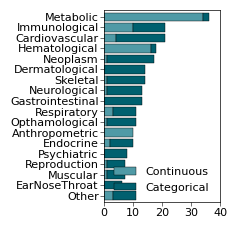

In [376]:
domains = final_shared_df_no_ukb.Domain.value_counts().reset_index()
domain_plot_values = domains[domains['count']>=5].Domain.values
domains = final_shared_df_no_ukb[final_shared_df_no_ukb.ClassificationFinal=='Q'].Domain.value_counts().reset_index()
domains_plot = domains[domains.Domain.isin(domain_plot_values)]
other=domains[~domains.Domain.isin(domain_plot_values)]['count'].sum()
domain_dict =domains_plot.set_index('Domain')['count'].to_dict()
domain_dict['Other'] = other

domains = final_shared_df_no_ukb[final_shared_df_no_ukb.ClassificationFinal=='CC'].Domain.value_counts().reset_index()
domains_plot2 = domains[domains.Domain.isin(domain_plot_values)]
other2=domains[~domains.Domain.isin(domain_plot_values)]['count'].sum()
domain_dict2 =domains_plot2.set_index('Domain')['count'].to_dict()
domain_dict2['Other'] = other2

_ = plt.figure(figsize=(1.5, 2.5))
plot_df = pd.DataFrame({'Continuous': domain_dict, 'Categorical': domain_dict2}).iloc[::-1]
plot_df['sum'] = np.nansum(plot_df, axis=1)
plot_df.at['Other', 'sum'] = 0
plot_df = plot_df.sort_values('sum')
plot_df.drop(columns='sum').plot(kind='barh', stacked=True, ax=plt.gca(),edgecolor='black', linewidth=0.3, width=0.8,
                                                                              color=[ '#509AA6', '#00606f',])
plt.xticks([0, 10, 20, 30, 40])
#plt.savefig(os.path.join(figdir, 'GCat_input_trait_types.svg'), bbox_inches='tight')

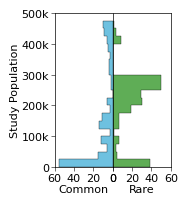

In [377]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(1.5, 2), sharey=True, gridspec_kw={'wspace':0})
bins=[x*25000 for x in range(0,  20)]
sns.histplot(y= final_shared_df_no_ukb.N_R, bins=bins, kde=False, element='step', ax=ax2, color='#5fad56', alpha=1, edgecolor='black')
sns.histplot(y= final_shared_df_no_ukb.N_C, bins=bins, kde=False, element='step', ax=ax1,color='#6ec1e0' , alpha=1, edgecolor='black')
ax1.invert_xaxis()
ax1.set_xlim(60, 0)
ax2.set_xlim(0, 60)
ax1.set_ylim(0, 500000)
_ = ax1.set_yticks([x*100000 for x in range(6)], labels=[0, '100k', '200k', '300k', '400k', '500k'])
ax1.set_ylabel('Study Population')
ax1.set_xticks([60, 40, 20, 0])
ax2.set_xticks([0, 20, 40, 60])
ax1.set_xlabel('Common')
ax2.set_xlabel('Rare')
ax2.tick_params(axis='y', size=0)

#plt.savefig(os.path.join(figdir, 'population_size_histograms_gcat.svg'), bbox_inches='tight')

In [378]:
final_shared_df_no_ukb.loc[:, ('N_R', 'N_C', 'Domain', 'ClassificationFinal', 'DISEASE/TRAIT')].to_csv(os.path.join(datadir, 'inputs', 'gcat_input_features_no_ukb.tsv'), sep='\t', index=False)

### Export results

In [379]:
inputdir = '/cellar/users/snwright/Data/RareCommon/inputs/March_2025'
with open(os.path.join(inputdir, 'common_no_ukb.traitlist'), 'w') as f:
    f.writelines('\n'.join(final_shared_df_no_ukb.StudyC.values)+'\n')
with open(os.path.join(inputdir, 'rare_no_ukb.traitlist'), 'w') as f:
    f.writelines('\n'.join(final_shared_df_no_ukb.StudyR.values)+'\n')

In [380]:
for i, t in tqdm(enumerate(final_shared_df_no_ukb.TRAIT_CODE.values)):
    accession = final_shared_df_no_ukb.iloc[i]['STUDY ACCESSION']
    trait = final_shared_df_no_ukb.iloc[i]['DISEASE/TRAIT']
    study_genes = gwas_genes[(gwas_genes.TRAIT_CODE==t) & (gwas_genes['STUDY ACCESSION']==accession) & (gwas_genes['DISEASE/TRAIT']==trait)]
    study_genes = study_genes.sort_values('logp', ascending=False)
    study_genes = study_genes.drop_duplicates(subset='Entrez')
    study_out = study_genes.loc[:, ('Entrez', 'MAPPED_GENE', 'P-VALUE', 'OR or BETA' )]
    study_out.columns = ['Entrez', 'Gene Symbol', 'P-value', 'Beta']
    study_out.to_csv(os.path.join(inputdir, accession+'_'+t+'_CV.txt'), sep='\t', index=False)

262it [00:17, 15.00it/s]


In [381]:
for i, t in tqdm(enumerate(final_shared_df_no_ukb.TRAIT_CODE.values)):
    pmid = final_shared_df_no_ukb.iloc[i]['PMID']
    trait = final_shared_df_no_ukb.iloc[i]['Reported Trait']
    study_genes = ravar_genes[(ravar_genes.TRAIT_CODE==t) & (ravar_genes['PMID']==pmid) & (ravar_genes['Reported Trait']==trait)]
    study_genes = study_genes.sort_values('P-value', ascending=True)
    study_genes = study_genes.drop_duplicates(subset='Entrez')
    study_out = study_genes.loc[:, ('Entrez', 'Gene Symbol','Ensembl ID',  'P-value')]
    study_out.to_csv(os.path.join(inputdir, str(int(pmid))+'_'+t+'_RV.txt'), sep='\t', index=False)

262it [00:03, 73.49it/s]
